# Predict points via RandomForestRegressor by sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Number of samples in each class

TEST_SAMPLE_NUMBER = 57092
TRAIN_SAMPLE_NUMBER = 285998

In [4]:
# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    error_template = "Array lengths should be equal. len(array1): {len1}, len(array2): {len2}"
    assert (len(array1) == len(array2)), error_template.format(len1=len(array1), len2=len(array2))
    
    # for one-dimension arrays np.linalg.norm works in one way and for two-dimension in other
    if array1.ndim == 1:
        length = len(array1)
        # array1[i:i+2] -- point i from first array
        # np.linalg.norm -- calculate distance between points
        distance = np.array([np.linalg.norm(array1[i:i+2] - array2[i:i+2]) for i in range(0,length,2)])
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(len(array1))])
    
    return result

In [5]:
test_data = pd.read_csv('src/test_data_points.csv', index_col=0)

In [6]:
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

In [7]:
# split ten frames in input and output data (we want to predict output by input)
test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [8]:
# we keep data like [n_features * n_samples] in pandas dataframe
# and random forest needs data as [n_samples * n_features] in np.array
def to_model(df):
    return np.array(df).T

In [9]:
# we want to test random forest with different parameters to choose the best one configureation
trees_number = range(10, 60, 10)

# we will keep results for each configuration here
result = []

for number_of_trees in trees_number:
    print(str(number_of_trees) + ": " + strftime("%Y-%m-%d %H:%M:%S", localtime()))
    est = RandomForestRegressor(n_jobs=-1, n_estimators=number_of_trees)

    est.fit(to_model(train_data), to_model(train_results))
    predicted_results = est.predict(to_model(test_data))
    
    np.save("src/Logs/161005_predicted_coordinates_rfr_trees_num_{}".format(number_of_trees), predicted_results)
    
    result.append(distance_for_each_point(np.array(test_results), predicted_results.T).sum() / TEST_SAMPLE_NUMBER)

10: 2016-10-05 10:57:13
20: 2016-10-05 10:58:36
30: 2016-10-05 11:01:02
40: 2016-10-05 11:04:33
50: 2016-10-05 11:09:24


Now, then calculation are done let's plot them to see the results. 

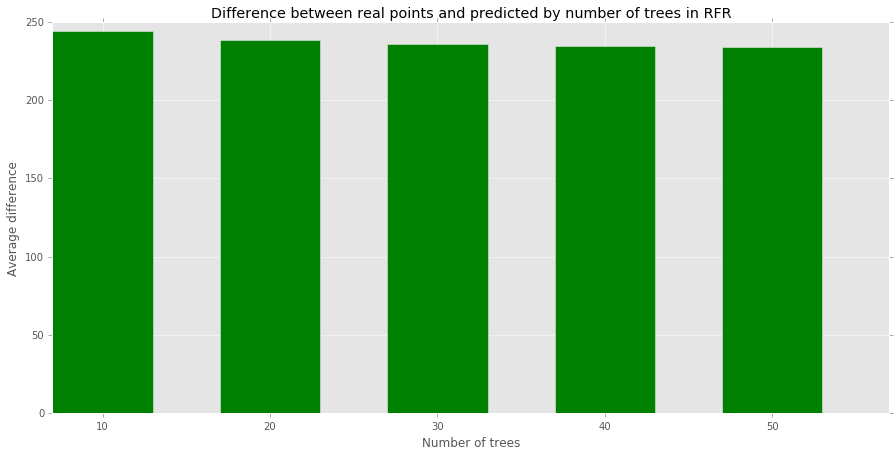

In [15]:
ind = trees_number
width = 6
result_bar = plt.bar(ind, result, width, color='g')

plt.ylabel('Average difference')
plt.xlabel('Number of trees')
plt.title('Difference between real points and predicted by number of trees in RFR')
plt.xticks(np.array(ind) + width/2, ind)
plt.savefig('src/Plots/161005_rfr_difference_by_trees_number.png')